In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
import os.path as path
from functions import utils

## User input

In [13]:
sample_file = utils.gui_fname().decode("utf-8")
tokens = sample_file.split("/")
base = path.basename(sample_file)
abs_dir = path.dirname(sample_file)
prefix = base.split('.')[0]
sample_prefix = abs_dir + '/' + prefix

In [3]:
sample_prefix

'E:/Ashlee/PacBio/20190215_D1-3_titration/PIB_blank/m190215_194458_42131_c000471012559900001500000112312130_s1_p0'

## Load data

In [4]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

print("Time passed: " + str(time() - start))

Time passed: 0.12579989433288574


## View a trace

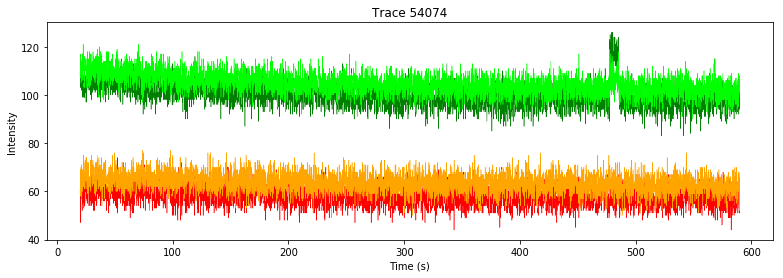

In [7]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
utils.plot_one_trace(raw_traces, traceID, time_axis, range(200, n_frames), colors)

## Preprocessing

In [8]:
foi = range(200, 300) # frames of interest
n_frames = len(foi)

In [32]:
traces = np.array(raw_traces[:, :, foi], dtype=np.uint8)
corrected = np.zeros(traces.shape)

In [34]:
for i in range(n_traces):
    corrected[i] = decode_array[traces[i]]

In [36]:
corrected[0, 0, :10]

array([257.32998657, 242.84732056, 238.08984375, 267.16879272,
       252.46655273, 247.63912964, 242.84732056, 252.46655273,
       224.0177002 , 257.32998657])

In [49]:
avg_intens = np.mean(corrected, axis=2)

## Plot intensity distributions

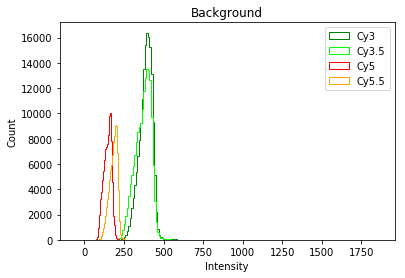

In [50]:
plt.figure()
for i in range(4):
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=200, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Background")
plt.legend(lasers)
plt.savefig(sample_prefix + '_hist.png')

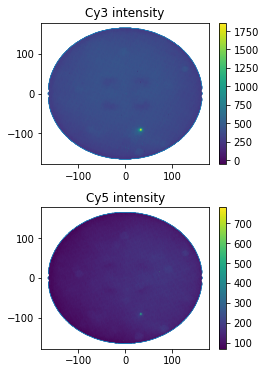

In [54]:
plt.figure(figsize=(3.75, 6))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.savefig(sample_prefix + '_grid.png')
plt.show()

In [52]:
np.savetxt(sample_prefix + "_background.csv", avg_intens, delimiter=",")